# # mecab 설치
  * https://velog.io/@jyong0719/konlpy-mecab-%EC%84%A4%EC%B9%98-window
  * python 버전 3.8까지 지원
    - 이를 위해서 downgrade도 감행해야함

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
mecab = Mecab('C:/mecab/mecab-ko-dic')

In [3]:
!ls

(clone)Naver Shopping Review Sentiment Analysis(on local on local for prediction).ipynb
printRate_Naver Shopping Review Sentiment Analysis(in local).ipynb
ratings_total.txt
shortVersion_printRateOfSentimentOfReview.ipynb


In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x2593ab43d90>)

In [5]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

In [7]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거

In [8]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('Review data for training :', len(train_data))
print('Review data for testing :', len(test_data))

Review data for training : 149931
Review data for testing : 49977


In [9]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


<ipython-input-9-5c91c21161d5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [10]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any') # 
print('Number of samples for testing after preprocessing :',len(test_data))

Number of samples for testing after preprocessing : 49977


<ipython-input-10-3b3c74c8720c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [11]:
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [12]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [13]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [14]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [15]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [16]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [17]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


In [18]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [20]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('Vocabulary size(단어 집합 크기) :',total_cnt)
print('number of rare words which appear under one time(등장 빈도가 %s번 이하인 희귀 단어의 수): %s'%(threshold - 1, rare_cnt))
print("rate of rare words in the vocabulary(단어 집합에서 희귀 단어의 비율):", (rare_cnt / total_cnt)*100)
print("rate of appearance frequency of rare words in total appearance frequency(전체 등장 빈도에서 희귀 단어 등장 빈도 비율):", (rare_freq / total_freq)*100)

Vocabulary size(단어 집합 크기) : 39998
number of rare words which appear under one time(등장 빈도가 1번 이하인 희귀 단어의 수): 18213
rate of rare words in the vocabulary(단어 집합에서 희귀 단어의 비율): 45.53477673883694
rate of appearance frequency of rare words in total appearance frequency(전체 등장 빈도에서 희귀 단어 등장 빈도 비율): 0.793569529160946


In [21]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('size of the vocabulary(단어 집합의 크기) :',vocab_size)

size of the vocabulary(단어 집합의 크기) : 21787


In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307528129606286


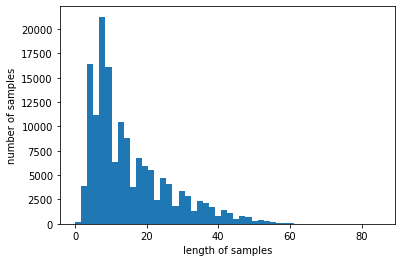

In [23]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [25]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [26]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [27]:
from tensorflow.keras.models import load_model

In [29]:
path = "C:/Sources/Projects/빅데이터과정_파이널project_유튜브 화장품 정보/res/300data_straightener/result/sensitivityAnalysis/sensitivityAnalysis_best_model_forNavershopping_Review.h5"
loaded_model = load_model(path)

In [30]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new
                                    # , verbose = 0 # 진행상황을 보여줄 형식
                                     ## 출처 : https://www.tensorflow.org/api_docs/python/tf/keras/Model
                                    ))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [31]:
new_sentence = '이 상품 진짜 좋아요... 저는 강추합니다. 대박'
new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
new_sentence = mecab.morphs(new_sentence)
new_sentence = [word for word in new_sentence if not word in stopwords]
encoded = tokenizer.texts_to_sequences([new_sentence])
pad_new = pad_sequences(encoded, maxlen = max_len)
loaded_model.predict(pad_new)

1/1 [==============================] - 0s 312ms/step


array([[0.9779813]], dtype=float32)

In [32]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 17ms/step
97.80% 확률로 긍정 리뷰입니다.


# # load 'naverReview_VodanaStraightner_blue40' file

In [34]:
tmp = pd.read_csv('C:/Sources/Projects/빅데이터과정_파이널project_유튜브 화장품 정보/res/300data_straightener/result/sensitivityAnalysis/crawledData_naverReviews_VodanaStraightner_blue40.csv')
tmp

,Unnamed: 0,type,category,review,star
0,1,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,보다나 고데기 신세계네요. 머리가 깔\n보다나 고데기 신세계네요. 머리가 깔끔하게 ...,평점5
1,2,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,평소 보다나 덕후라 이번에 보다나에서 물결고데기가 나왔다는 소식을 듣고 얼른~! 4...,평점5
2,3,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,"고데기는 전부 보다나제품으로 가지고있어요판고데기,봉고데기36mm 로 가지고있는데 물...",평점5
3,4,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,한달 후기를 쓰자면제가 기존에 산 스프링 컬렉션 >초록색은지금 나온 파란색보다 무거...,평점5
4,5,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,예전부터 갖고싶어서 눈여겨보다 보통 고데기에 비해 가격이 좀 부담되어 미루다 이번에...,평점5
...,...,...,...,...,...
95,96,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,처음엔 좀 어색했는데 두번째부터는 잘하고있어요~~ 예쁘게 물결웨이브 쉽게하게되어서 ...,평점5
96,97,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,평이좋아서구매해봤는데색상이나배송도빠르고넘맘에드네여 ㅎ똥손이라서잘사용할거같아여 ㅎ\n...,평점5
97,98,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,진짜 쉬워요. 긴머린데 다 하는데 10분정도 걸리고 요령 없어도 잘 되던데 저는 너...,평점5
98,99,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,제가 똥손이라그런지 모양이예쁘게안나오네요 ㅠㅠ 연습좀해봐야겠습니다.. 제품자체는좋아...,평점5


# # print rates of positive and negative reviews
  * positive %
  * negative %

In [35]:
def sentiment_predict_NaverShoppingReviews(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))

  if(score > 0.5):
    positive_reviews.append(score)
  else:
    negative_reviews.append(score)
  
  return positive_reviews, negative_reviews

In [36]:
reviews = tmp['review']
reviews

0     보다나 고데기 신세계네요. 머리가 깔\n보다나 고데기 신세계네요. 머리가 깔끔하게 ...
1     평소 보다나 덕후라 이번에 보다나에서 물결고데기가 나왔다는 소식을 듣고 얼른~! 4...
2     고데기는 전부 보다나제품으로 가지고있어요판고데기,봉고데기36mm 로 가지고있는데 물...
3     한달 후기를 쓰자면제가 기존에 산 스프링 컬렉션 >초록색은지금 나온 파란색보다 무거...
4     예전부터 갖고싶어서 눈여겨보다 보통 고데기에 비해 가격이 좀 부담되어 미루다 이번에...
                            ...                        
95    처음엔 좀 어색했는데 두번째부터는 잘하고있어요~~ 예쁘게 물결웨이브 쉽게하게되어서 ...
96    평이좋아서구매해봤는데색상이나배송도빠르고넘맘에드네여 ㅎ똥손이라서잘사용할거같아여 ㅎ\n...
97    진짜 쉬워요. 긴머린데 다 하는데 10분정도 걸리고 요령 없어도 잘 되던데 저는 너...
98    제가 똥손이라그런지 모양이예쁘게안나오네요 ㅠㅠ 연습좀해봐야겠습니다.. 제품자체는좋아...
99    받자말자 테스트해보니 이쁘게나오는것같은데 단발머리하기에 손에 만이 익혀야될듯싶습니다...
Name: review, Length: 100, dtype: object

In [37]:
positive_reviews = list()
negative_reviews = list()

def rate_n_or_p_reviews(reviews) :
  for review in reviews :
    positive_reviews, negative_reviews = sentiment_predict_NaverShoppingReviews(review)
  total = len(positive_reviews)+len(negative_reviews)
  print(f"positive : {len(positive_reviews) / total * 100} % , negative : {len(negative_reviews) / total * 100} % ")

In [38]:
rate_n_or_p_reviews(reviews)

1/1 [==============================] - 0s 16ms/step
positive : 81.0 % , negative : 19.0 % 


In [43]:
tmp['review'][0]

'보다나 고데기 신세계네요. 머리가 깔\n보다나 고데기 신세계네요. 머리가 깔끔하게 정돈 되면서 굵은 웨이브라서 자연스러워요\n처음 사용하는거라서 조심스러워서 강하게 안하고 살짝씩만 찝어줘 봤는데 머릿결 손상도 없고 굉장히 자연스러운 연출을 할 수 있어서 좋았답니다.\n고데기 하고 나서 웨이브 유지되는 시간도 길어서 금방 풀리거나 하지 않는 점이 맘에 들어요\n여러 굵기중에 이 굵기를 선택하기를 잘 한거 같아요\n너무 촘촘한 웨이브는 부담스러워서 자연스러운 물결머리를 원했거든요\n웨이브를 더 굵게 하고 싶으면 고데기 집었던 간견을 멀리 띄우면 더 굵게 되기도 하고 간견을 바짝 붙히면 좀더 촘촘한 웨이브도 연출 할 수 있더라구요\n저처럼 머리 잘 못 만지는 빠르고 자연스러운 연출을 할 수 있는점이 좋습니다\n분들은 훨씬 더 예쁠거예요\n고데기 웨이브 잡는 앞쪽이 두껍다 보니 좀 무게가 있긴하지만 쓸만해요\n웨이브 위쪽은 뜨거우니까 조심하세요\n장갑이랑 머리집게도 들어 있어서\n저는 고데기를 나란히 평면으로 집어줘서 머리결이 전체적으로 같은 물결이 동일하게 나왔지만 고데기를 비스듬하게 해서 열을 가해주면 훨씬더 자연스러운 웨이브를 만들 수도 있네요\n사진의 ㅡ 노란머리는 고데기로 가볍게 열을 가열해서 바로 찍어 본 사진이에요\n사진의 ㅡ 검정머리는 정식으로 한건 아니고 전날 저녁에 시범 삼아 가볍게 고데기로 집어줘 봤는데, 하루 자고나면 다 풀릴 줄 알았는데 안풀려서 그대로 외출했어요\n이사진은 다음날 오후사진이구요. 오른쪽 머리쪽은 아주 살짝 댔다가 뗐더니 좀 약하게 나왔어요.\n고데기 한 다음날 저녁에 머리 감기 전까지 약간풀리긴 했지만, 웨이브가 잘 유지가 되더라구요\n당일 웨이브는 진짜 잘 안풀리고 유지됐어요\n단, 비오는날 습도 높은날은 풀리겠죠\n고데기 하기전에 에센스 발라서 머릿결 보호 하고 사용하세요. 그럼 머리결어 윤기가 흐르네요\n고데시 감은머리를 덜 말리고 사용하면 머릿결 상하는건 다 아시죠? 잘 말리시고 사용하세요^^'